In [1]:
# 使用pandas读取数据
import pandas as pd


data_path = "./data/adult.data"
raw_data = pd.read_csv(data_path)
## 选取需要使用的列
cols = ["workclass", "sex", "age", "education_num",
        "capital_gain", "capital_loss", "hours_per_week", "label"]
data = raw_data[cols]

In [3]:
# 将label转换为可以运算的变量
data.loc[:, "label_code"] = pd.Categorical(data.label).codes
data.head()

,workclass,sex,age,education_num,capital_gain,capital_loss,hours_per_week,label,label_code
0,State-gov,Male,39,13,2174,0,40,<=50K,0
1,Self-emp-not-inc,Male,50,13,0,0,13,<=50K,0
2,Private,Male,38,9,0,0,40,<=50K,0
3,Private,Male,53,7,0,0,40,<=50K,0
4,Private,Female,28,13,0,0,40,<=50K,0


In [4]:
print(data["sex"].unique())
print(data["workclass"].unique())

[' Male' ' Female']
[' State-gov' ' Self-emp-not-inc' ' Private' ' Federal-gov' ' Local-gov'
 ' ?' ' Self-emp-inc' ' Without-pay' ' Never-worked']


显示sex, label交叉报表：
sex      label 
 Female   <=50K     9592
          >50K      1179
 Male     <=50K    15128
          >50K      6662
dtype: int64


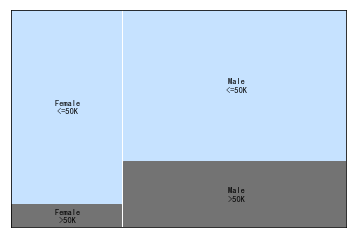

In [6]:
# 利用交叉报表，直观了解数据
import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic


# 计算sex, label交叉报表
cross1 = pd.crosstab(data["sex"], data["label"])
print("显示sex, label交叉报表：")
print(cross1.stack())
# 将交叉报表图形化
props = lambda key: {"color": "0.45"} if ' >50K' in key else {"color": "#C6E2FF"}
mosaic(cross1[[" >50K", " <=50K"]].stack(), properties=props, axes_label=False)
plt.show()

In [7]:
# 将数据分为训练集和测试集
from sklearn.model_selection import train_test_split


train_set, test_set = train_test_split(data, test_size=0.8, random_state=2111)

In [8]:
# 训练模型
import statsmodels.api as sm


c_formula = "label_code ~ C(sex) + C(workclass) + education_num + capital_gain + capital_loss + hours_per_week"
c_model = sm.Logit.from_formula(c_formula, data=train_set)
c_model = c_model.fit()

         Current function value: 0.401027
         Iterations: 35


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [9]:
# 展示模型结果
print(c_model.summary())

                           Logit Regression Results                           
Dep. Variable:             label_code   No. Observations:                 6512
Model:                          Logit   Df Residuals:                     6498
Method:                           MLE   Df Model:                           13
Date:                Sat, 01 Jun 2019   Pseudo R-squ.:                  0.2732
Time:                        21:59:43   Log-Likelihood:                -2611.5
converged:                      False   LL-Null:                       -3593.4
                                        LLR p-value:                     0.000
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            -7.8382      0.305    -25.734      0.000      -8.435      -7.241
C(sex)[T. Male]                       1.2566      0.090     13

In [10]:
# 去掉不显著的虚拟变量
import numpy as np


# 定义workclass的类别顺序，数组里的第一个值为基准类别
l = [" ?", " Never-worked", " Without-pay", " State-gov",
     " Self-emp-not-inc", " Private", " Federal-gov",
     " Local-gov",  " Self-emp-inc"]
# 定义各个类别对应的虚拟变量
contrast = np.eye(9, 6, k=-3)
contrast

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]])

In [11]:
# 为每个虚拟变量命名
from patsy import ContrastMatrix


contrast_mat = ContrastMatrix(contrast, l[3:])
contrast_mat

ContrastMatrix(array([[0., 0., 0., 0., 0., 0.],
                      [0., 0., 0., 0., 0., 0.],
                      [0., 0., 0., 0., 0., 0.],
                      [1., 0., 0., 0., 0., 0.],
                      [0., 1., 0., 0., 0., 0.],
                      [0., 0., 1., 0., 0., 0.],
                      [0., 0., 0., 1., 0., 0.],
                      [0., 0., 0., 0., 1., 0.],
                      [0., 0., 0., 0., 0., 1.]]),
               [' State-gov',
                ' Self-emp-not-inc',
                ' Private',
                ' Federal-gov',
                ' Local-gov',
                ' Self-emp-inc'])

In [12]:
# 将不显著的虚拟变量剔除，搭建模型
m_formula = """label_code ~ C(workclass, contrast_mat, levels=l)
        + C(sex) + education_num + capital_gain
        + capital_loss + hours_per_week"""
m_model = sm.Logit.from_formula(m_formula, data=train_set)
m_model = m_model.fit()

Optimization terminated successfully.
         Current function value: 0.401037
         Iterations 8


In [13]:
# 展示模型结果
print(m_model.summary())

                           Logit Regression Results                           
Dep. Variable:             label_code   No. Observations:                 6512
Model:                          Logit   Df Residuals:                     6500
Method:                           MLE   Df Model:                           11
Date:                Sat, 01 Jun 2019   Pseudo R-squ.:                  0.2732
Time:                        22:03:14   Log-Likelihood:                -2611.6
converged:                       True   LL-Null:                       -3593.4
                                        LLR p-value:                     0.000
                                                            coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------
Intercept                                                -7.8418      0.304    -25.757      0.000      -8.438      -7.245
C(

In [14]:
# 搭建不使用类别变量的模型
b_formula = """label_code ~ education_num + capital_gain
        + capital_loss + hours_per_week"""
b_model = sm.Logit.from_formula(b_formula, data=train_set)
b_model = b_model.fit()

Optimization terminated successfully.
         Current function value: 0.422974
         Iterations 8


In [15]:
# 得到预测结果
test_set.loc[:, "b_prob"] = b_model.predict(test_set)
test_set.loc[:, "m_prob"] = m_model.predict(test_set)
test_set.head()

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,workclass,sex,age,education_num,capital_gain,capital_loss,hours_per_week,label,label_code,b_prob,m_prob
1704,?,Female,22,10,0,0,35,<=50K,0,0.128792,0.027842
1376,Self-emp-not-inc,Male,44,9,0,0,55,<=50K,0,0.182111,0.199595
14634,Private,Female,39,10,0,0,40,<=50K,0,0.151025,0.063969
21554,Private,Female,29,13,0,0,45,>50K,1,0.366086,0.176178
20959,Private,Female,43,9,0,0,44,<=50K,0,0.129057,0.051503


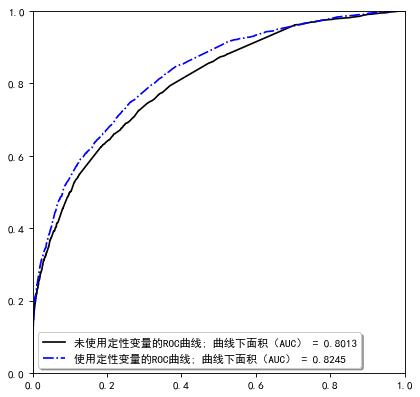

In [16]:
# ROC曲线
from sklearn import metrics

# 计算b_model的预测效果
b_fpr, b_tpr, _ = metrics.roc_curve(test_set["label_code"], test_set["b_prob"])
b_auc = metrics.auc(b_fpr, b_tpr)
# 计算m_model的预测效果
m_fpr, m_tpr, _ = metrics.roc_curve(test_set["label_code"], test_set["m_prob"])
m_auc = metrics.auc(m_fpr, m_tpr)
# 画图
fig = plt.figure(figsize=(6, 6), dpi=80)
# 在图形框里只画一幅图
ax = fig.add_subplot(1, 1, 1)
ax.plot(b_fpr, b_tpr, "k",
        label="%s; %s = %0.4f" % ("未使用定性变量的ROC曲线", "曲线下面积（AUC）", b_auc))
ax.plot(m_fpr, m_tpr, "b-.",
        label="%s; %s = %0.4f" % ("使用定性变量的ROC曲线", "曲线下面积（AUC）", m_auc))
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
legend = plt.legend(shadow=True)
plt.show()